In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load Excel file and check sheets
excel_file = pd.ExcelFile("online_retail_II.xlsx")
print("Sheet names:", excel_file.sheet_names)

# Load the data from the required sheet
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

Sheet names: ['Year 2009-2010', 'Year 2010-2011']


In [6]:
# Display basic info
print("Initial Data Shape:", df.shape)
print(df.head())

# Drop rows with missing Customer ID
df.dropna(subset=["Customer ID"], inplace=True)

Initial Data Shape: (541910, 8)
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  


In [7]:
# Rename columns for consistency
df.rename(columns={
    'Customer ID': 'CustomerID',
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice'
}, inplace=True)

# Add TotalPrice column
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Set snapshot date for Recency calculation (next day after last invoice)
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

In [8]:
# Aggregate data per customer
customer_df = df.groupby("CustomerID").agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum',                                      # Monetary
    'Quantity': 'sum',                                        # Total quantity
    'UnitPrice': 'mean',                                      # Avg unit price
    'Country': 'first'                                        # Country
}).reset_index()

# Rename columns
customer_df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary',
    'Quantity': 'TotalQuantity',
    'UnitPrice': 'AvgUnitPrice'
}, inplace=True)

In [9]:
# Display the aggregated customer data
print("Customer Data Sample:")
print(customer_df.head())

# Filter out extreme or invalid values
filtered_df = customer_df[(customer_df['Monetary'] > 0) & 
                          (customer_df['Frequency'] > 0) & 
                          (customer_df['Recency'] >= 0)]

Customer Data Sample:
   CustomerID  Recency  Frequency  Monetary  TotalQuantity  AvgUnitPrice  \
0     12346.0      326          2      0.00              0      1.040000   
1     12347.0        2          7   4310.00           2458      2.644011   
2     12348.0       75          4   1797.24           2341      5.764839   
3     12349.0       19          1   1757.55            631      8.289041   
4     12350.0      310          1    334.40            197      3.841176   

          Country  
0  United Kingdom  
1         Iceland  
2         Finland  
3           Italy  
4          Norway  


In [10]:
# Create features (X) and target (y)
X = filtered_df[['Recency', 'Frequency', 'Monetary']]
y = filtered_df['Monetary'] * filtered_df['Frequency']  # Proxy CLV

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [12]:
# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# Predictions
y_pred = model.predict(X_test)

In [14]:
# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.4174526591155371
RMSE: 932256.6113661354


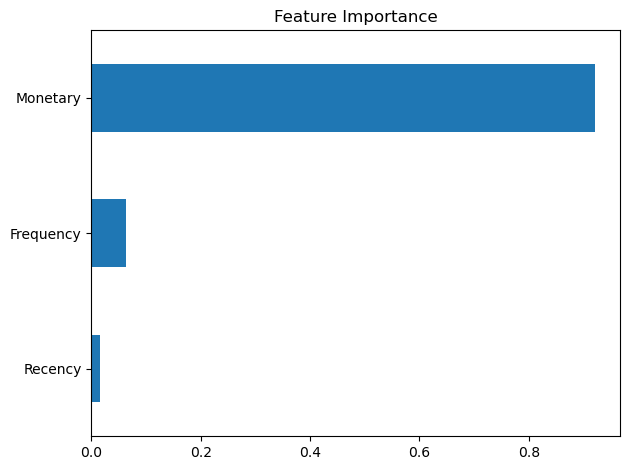

In [15]:
# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=['Recency', 'Frequency', 'Monetary'])
feature_importance.sort_values().plot(kind='barh', title='Feature Importance')
plt.tight_layout()
plt.show()

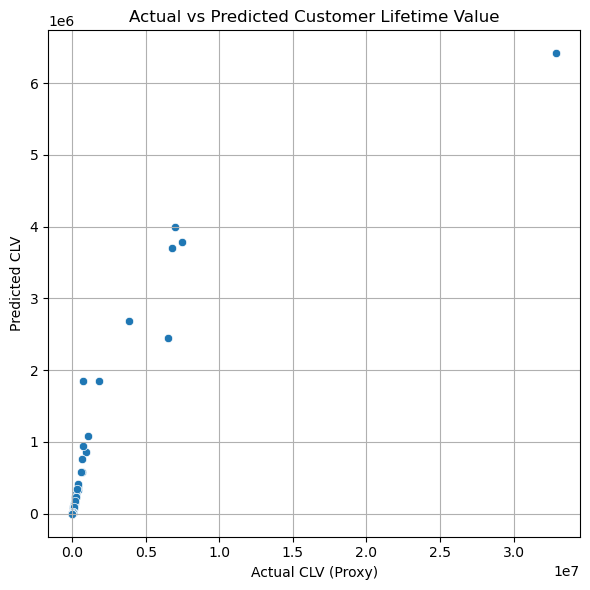

In [16]:
# Optional: Plot predicted vs actual CLV
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CLV (Proxy)")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted Customer Lifetime Value")
plt.grid(True)
plt.tight_layout()
plt.show()